# Sesión 2

In [1037]:
import nltk
# Punkt permite separar un texto en frases.
nltk.download('punkt')
# Descarga todas las palabras vacias, es decir, aquellas que no aportan nada al significado del texto
nltk.download('stopwords')
#Paquete WordNetLemmatizer, este es usado para encontrar el lema de cada palabr
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/marcosrodrigo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/marcosrodrigo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/marcosrodrigo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/marcosrodrigo/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [1038]:
# Librerias
import pandas as pd
import numpy as np
import sys
!{sys.executable} -m pip install pandas-profiling
!pip install vaderSentiment
!pip install seaborn
!pip install imbalanced-learn
!pip install nltk
!pip install scipy
import nltk
nltk.data.path.append("C:/Users/Felipe Jaimes/nltk_data")
nltk.download('punkt', force=True)
import re, string, unicodedata
import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from datetime import datetime
from sklearn.model_selection import cross_val_score

from sklearn.base import BaseEstimator, ClassifierMixin
import seaborn as sns
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

  Using cached joblib-1.1.1-py2.py3-none-any.whl.metadata (5.2 kB)
Using cached joblib-1.1.1-py2.py3-none-any.whl (309 kB)
  Attempting uninstall: joblib
    Found existing installation: joblib 1.4.2
    Uninstalling joblib-1.4.2:
      Successfully uninstalled joblib-1.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-learn 1.5.1 requires joblib>=1.2.0, but you have joblib 1.1.1 which is incompatible.
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.1
    Uninstalling joblib-1.1.1:
      Successfully uninstalled joblib-1.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/marcosrodrigo/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


1. Perfilamiento, entendimiento de los datos y  análisis de la calidad de los datos

Carga de datos

In [1039]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/marcosrodrigo/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [1040]:
data_cargada=pd.read_csv('Data/fake_news_spanish.csv', sep=';', encoding = 'utf-8')
# Asignación a una nueva variable de los datos leidos
data=data_cargada

In [1041]:
data.head(10)

,ID,Label,Titulo,Descripcion,Fecha
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,02/06/2023
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,01/10/2023
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,25/04/2022
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",03/01/2022
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",09/03/2018
5,ID,1,"El PNV consolida su mayoría, el PSE salva los ...",Los nacionalistas consiguen las alcaldías de B...,26/05/2019
6,ID,0,El exconsejero Núria Marín pide el indulto en ...,Sus familiares aluden a su honestidad e integr...,16/09/2022
7,ID,1,La Fiscalía pide prisión incondicional para lo...,Suprime el delito de rebelión que les imputó i...,26/09/2019
8,ID,1,"José Manuel Pérez Tornero, el creador de la te...",El futuro presidente de RTVE es licenciado en ...,25/02/2021
9,ID,0,La 'Ayusización' del BNG: Santiago Abascal ins...,Pablo Santiago Abascal planea vivir de las ren...,10/05/2021


In [1042]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57063 entries, 0 to 57062
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           57063 non-null  object
 1   Label        57063 non-null  int64 
 2   Titulo       57047 non-null  object
 3   Descripcion  57063 non-null  object
 4   Fecha        57063 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.2+ MB


In [1043]:
data.shape

(57063, 5)

En este punto del análisis, se puede ver que la unica columna que tiene datos nulos es Titulo, con un total de 16 datos nulos.

Inicializacion de variables

In [1044]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/marcosrodrigo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [1045]:
p = inflect.engine()
analyzer = SentimentIntensityAnalyzer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('spanish'))

### Entendimiento de los datos

In [1046]:
from scipy import stats as st

textos_analisis = data.copy()
textos_analisis['Conteo_Titulo'] = [len(str(x)) for x in textos_analisis['Titulo']]
textos_analisis['Conteo_Descripcion'] = [len(str(x)) for x in textos_analisis['Descripcion']]

#textos_analisis['Moda'] =
textos_analisis['Max_Titulo'] = [[max([len(str(x)) for x in str(i).split(' ')])][0] for i in textos_analisis['Titulo']]
textos_analisis['Max_Titulo'] = [[max([len(str(x)) for x in str(i).split(' ')])][0] for i in textos_analisis['Titulo']]
textos_analisis['Min_Descripcion'] = [[min([len(str(x)) for x in str(i).split(' ')])][0] for i in textos_analisis['Descripcion']]
textos_analisis['Min_Descripcion'] = [[min([len(str(x)) for x in str(i).split(' ')])][0] for i in textos_analisis['Descripcion']]

textos_analisis  

,ID,Label,Titulo,Descripcion,Fecha,Conteo_Titulo,Conteo_Descripcion,Max_Titulo,Min_Descripcion
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,02/06/2023,77,218,9,1
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,01/10/2023,104,3251,10,1
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,25/04/2022,77,169,10,2
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",03/01/2022,110,133,12,2
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",09/03/2018,72,242,11,1
...,...,...,...,...,...,...,...,...,...
57058,ID,1,El Defensor del Pueblo reclama a la Comunidad ...,El gobierno regional han indicado que la atenc...,08/06/2021,116,244,9,1
57059,ID,0,El EQUO plantea ceder la presidencia de la Com...,Si la higiene democrática nos lleva a esa exig...,08/09/2020,100,314,11,1
57060,ID,1,Alberto Garzón: 'Que los Borbones son unos lad...,El coordinador federal de IU asegura que la mo...,12/07/2018,90,70,14,2
57061,ID,1,Vox exige entrar en el Gobierno de Castilla y ...,Santiago Abascal: Vox tiene el derecho y el de...,13/02/2022,118,232,16,1


2. Preparación de los datos

Limpieza de datos y toquenización 

In [1047]:
# Convertir columnas de texto a string
data['Titulo'] = data['Titulo'].astype('string')
data['Descripcion'] = data['Descripcion'].astype('string')

# Convertir Fecha a datetime
data['Fecha'] = pd.to_datetime(data['Fecha'], format='%d/%m/%Y')
df=data

Vamos a buscar los datos Nulos


In [1048]:
df.isnull().sum()

ID              0
Label           0
Titulo         16
Descripcion     0
Fecha           0
dtype: int64

Revisemos que pasa en la columna titulo ya que es la unica fila que tiene titulos vacios

In [1049]:
df[df.isna().any(axis=1)]

,ID,Label,Titulo,Descripcion,Fecha
3243,ID,0,<NA>,"Hace unos 75 años, Hermann Göring testificó en...",2019-06-16
4189,ID,0,<NA>,"Evidentemente, Barak Obama ha sido arrestado e...",2022-03-10
5041,ID,0,<NA>,"""Después de convertirme en presidente, le pedí...",2022-03-16
5644,ID,0,<NA>,Me pasaron de buena fuente hoy (un vecino del ...,2023-04-08
7345,ID,0,<NA>,Defienden dichos con capitulos de Don Gato. C...,2023-07-02
7652,ID,0,<NA>,Lean (y vean la imagen) con mucha atención: S...,2018-08-04
9700,ID,0,<NA>,¿Sabías que Francisco Sagasti salió a marchar ...,2018-12-26
15159,ID,0,<NA>,Declarar a Bill Gates enemigo público y proces...,2024-08-02
19415,ID,0,<NA>,Con el fin de captar votos están dispuestos a ...,2017-10-28
24806,ID,0,<NA>,CUANDO LAS IMÁGENES HABLAN MÁS QUE PALABRAS. ...,2018-06-28


In [1050]:
def imputar_titulo_desde_descripcion(titulo, descripcion, max_palabras=5):
    if pd.isna(titulo):  
        if isinstance(descripcion, str):  
            palabras = descripcion.split()  
            return ' '.join(palabras[:max_palabras])  
        return ''  
    return titulo  

print(f"Filas con Título nulo antes: {df['Titulo'].isna().sum()}")
df['Titulo'] = df.apply(lambda row: imputar_titulo_desde_descripcion(row['Titulo'], row['Descripcion']), axis=1)
print(f"Filas con Título nulo después: {df['Titulo'].isna().sum()}")

Filas con Título nulo antes: 16
Filas con Título nulo después: 0


In [1051]:
df.dtypes

ID                     object
Label                   int64
Titulo                 object
Descripcion    string[python]
Fecha          datetime64[ns]
dtype: object

In [1052]:
palabras_sospechosas = set([
    'secreto', 'impactante', 'milagrosa', 'urgente', 'impresionante', 'sorprendente', 'insólito',
    'descubierto', 'alerta', 'indignante', 'peligroso', 'exclusivo', 'aterrador', 'impresionante',
    'conspiración', 'oculto', 'prohibido', 'mentira', 'falso', 'desmentido', 'engaño',
    'corrupción', 'censurado', 'revelación', 'encubierto', 'manipulación', 'trampa',
    'milagro', 'cura', 'prohibida', 'veneno', 'dañino', 'tóxico', 'ilegal', 'secreto',
    'remedio', 'increíble', 'fantástico', 'desconocido', 'nunca visto', 'no quieren que sepas',
    'última hora', 'no creerás', 'nadie lo esperaba', 'urgente', 'alerta máxima', 'devastador',
    'infalible', 'descubre', 'inexplicable', 'definitivo', 'drástico', 'imperdible', 'viral',
    'terror', 'amenaza', 'pánico', 'apocalipsis', 'devastador', 'tragedia', 'colapso',
    'desastre', 'crisis', 'fracaso', 'fin del mundo', 'poderoso', 'letal', 'brutal',
    'gana dinero', 'secreto bancario', 'hack', 'truco', 'fórmula mágica', 'sistema infalible',
    'multiplica tu dinero', 'solución definitiva', 'inversión garantizada', 'fácil y rápido',
    'químico peligroso', 'cura definitiva', 'anticancerígeno', 'natural y seguro', 'sin efectos secundarios',
    'poder de la mente', 'médicos lo odian', 'ciencia lo confirma', 'demostrado',
    'impresionante', 'alucinante', 'no lo podrás creer', 'revolucionario', 'radical', 'inigualable',
    'impactante', 'sorprendente', 'irrepetible', 'shock', 'devastador', 'asombroso'
])

In [1053]:
def preprocess_text(text):
    if not isinstance(text, str):
        return ''
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')    
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [re.sub(r'[^\w\s]', '', word) for word in tokens if word.isalnum()]    
    # tokens = [p.number_to_words(word) if word.isdigit() else word for word in tokens]
    # tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)  # Devolver como cadena para TF-IDF

In [1054]:
df['Titulo_procesado'] = df['Titulo'].apply(lambda x: preprocess_text(x))
df['Descripcion_procesado'] = df['Descripcion'].apply(lambda x: preprocess_text(x))

In [1055]:
def extract_text_features(text):
    if not isinstance(text, str):
        return pd.Series([0, 0, 0, 0])
    tokens = word_tokenize(text.lower())
    num_palabras = len(tokens)
    tokens_lematizados = [lemmatizer.lemmatize(token) for token in tokens]
    num_sospechosas = sum(1 for palabra in tokens if palabra in palabras_sospechosas)
    sentimiento = analyzer.polarity_scores(text)['compound']
    num_exclamaciones = text.count('!') + text.count('¡')
    return pd.Series([num_palabras, num_sospechosas, sentimiento, num_exclamaciones])

In [ ]:
df[['Numero_Palabras_Titulo', 'Numero_Sospechosas_Titulo', 'Sentimiento_Titulo', 'Exclamaciones_Titulo']] = df['Titulo'].apply(lambda x: extract_text_features(x))
df[['Numero_Palabras_Descripcion', 'Numero_Sospechosas_Descripcion', 'Sentimiento_Descripcion', 'Exclamaciones_Descripcion']] = df['Descripcion'].apply(lambda x: extract_text_features(x))

In [ ]:
# df['Titulo_procesado'] = df['Titulo_procesado'].apply(contractions.fix) 

Normalización 

In [ ]:
df

,ID,Label,Titulo,Descripcion,Fecha,Titulo_procesado,Descripcion_procesado,Numero_Palabras_Titulo,Numero_Sospechosas_Titulo,Sentimiento_Titulo,Exclamaciones_Titulo,Numero_Palabras_Descripcion,Numero_Sospechosas_Descripcion,Sentimiento_Descripcion,Exclamaciones_Descripcion
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,2023-06-02,guardian va con sanchez necesita que su apuest...,el diario britanico publico este pasado jueves...,16.0,0.0,0.0,0.0,37.0,0.0,0.0000,0.0
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,2023-10-01,revelan que el gobierno negocio la liberacion ...,revelan que el gobierno negocio la liberacion ...,18.0,0.0,0.0,0.0,595.0,3.0,-0.8177,0.0
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,2022-04-25,el o nunca de joan fuster sobre el estatuto va...,el valencianismo convoca en castello su fiesta...,15.0,0.0,0.0,0.0,32.0,0.0,0.4767,0.0
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",2022-01-03,iglesias alienta a yolanda diaz erc y eh bildu...,en politica igual que hay que negociar con los...,20.0,0.0,0.0,0.0,23.0,0.0,0.3400,0.0
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",2018-03-09,puigdemont seria ninguna tragedia una repetici...,en una entrevista en el punt avui el lider de ...,12.0,1.0,0.0,0.0,47.0,0.0,0.3400,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57058,ID,1,El Defensor del Pueblo reclama a la Comunidad ...,El gobierno regional han indicado que la atenc...,2021-06-08,el defensor del pueblo reclama a la comunidad ...,el gobierno regional han indicado que la atenc...,20.0,0.0,0.0,0.0,45.0,0.0,-0.2960,0.0
57059,ID,0,El EQUO plantea ceder la presidencia de la Com...,Si la higiene democrática nos lleva a esa exig...,2020-09-08,el equo plantea ceder la presidencia de la com...,si la higiene democratica no lleva a esa exige...,20.0,0.0,0.0,0.0,54.0,0.0,-0.2960,0.0
57060,ID,1,Alberto Garzón: 'Que los Borbones son unos lad...,El coordinador federal de IU asegura que la mo...,2018-07-12,alberto garzon los borbones son unos ladrones ...,el coordinador federal de iu asegura que la mo...,15.0,0.0,0.0,0.0,12.0,0.0,0.0000,0.0
57061,ID,1,Vox exige entrar en el Gobierno de Castilla y ...,Santiago Abascal: Vox tiene el derecho y el de...,2022-02-13,vox exige entrar en el gobierno de castilla y ...,santiago abascal vox tiene el derecho y el deb...,22.0,0.0,0.0,0.0,48.0,0.0,-0.2960,0.0


In [ ]:
# df['titulo_new'] = df['titulo_new'].apply(contractions.fix) 
# df['description_new'] = df['description_new'].apply(contractions.fix) 


# Regresion Logistica

In [ ]:
cantidadSi = (df["Label"] == 1).sum()
cantidadNo = (df["Label"] == 0).sum()
print(f"Noticias Verdaderas (1): {cantidadSi}")
print(f"Noticias Falsas (0): {cantidadNo}")
print(f"Cantidad de diferencia: {cantidadSi-cantidadNo}")

Noticias Verdaderas (1): 33158
Noticias Falsas (0): 23905
Cantidad de diferencia9253


Ya que hay una gran cantidad de desbalance entre las noticias verdaderas y falsas con una diferencia de 9253 datos entonces construiremos primero el modelo sin SMOTE que es una tecnica para generar datos sinteticos y otra usando SMOTE 

### Modelo de regresion logistica sin SMOTE

In [ ]:
tfidf = TfidfVectorizer(max_features=500)
X_tfidf = tfidf.fit_transform(df['Titulo'] + ' ' + df['Descripcion']).toarray()  # Original
# X_tfidf = tfidf.fit_transform(df['Titulo_procesado'] + ' ' + df['Descripcion_procesado']).toarray() # Si es que lo hago con datos preprocesados
X_tfidf_df = pd.DataFrame(X_tfidf, columns=[f'tfidf_{i}' for i in range(X_tfidf.shape[1])])

In [ ]:
X = pd.concat([df[['Numero_Palabras_Titulo', 'Numero_Sospechosas_Titulo', 'Sentimiento_Titulo', 'Exclamaciones_Titulo',
                   'Numero_Palabras_Descripcion', 'Numero_Sospechosas_Descripcion', 'Sentimiento_Descripcion', 'Exclamaciones_Descripcion']],
               X_tfidf_df], axis=1)
y = df['Label']

In [ ]:
X = X.astype(float)

In [ ]:
modelo = LogisticRegression(max_iter=1000)
modelo.fit(X_train_balanced, y_train_balanced)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
modelo = LogisticRegression(max_iter=1000, class_weight='balanced')
modelo.fit(X_train, y_train)

In [ ]:
y_pred = modelo.predict(X_test)

In [ ]:
print(f"Precisión del modelo: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print("\nReporte completo:")
print(classification_report(y_test, y_pred, target_names=['Falsa', 'Verdadera']))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Falsa', 'Verdadera'], yticklabels=['Falsa', 'Verdadera'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

In [ ]:
print("\nPesos de las características numéricas:")
for feature, coef in zip(X.columns[:6], modelo.coef_[0][:6]):
    print(f"{feature}: {coef:.4f}")

### Modelo de regresion logistica con SMOTE

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
smote = SMOTE(sampling_strategy=0.9, random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

In [ ]:
modelo = LogisticRegression(max_iter=1000)
modelo.fit(X_train_balanced, y_train_balanced)

/Users/marcosrodrigo/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

In [ ]:
y_pred = modelo.predict(X_test)
print(f"Precisión del modelo: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print("\nReporte completo:")
print(classification_report(y_test, y_pred, target_names=['Falsa', 'Verdadera']))

Precisión del modelo: 86.53%

Reporte completo:
              precision    recall  f1-score   support

       Falsa       0.89      0.78      0.83      5999
   Verdadera       0.85      0.93      0.89      8267

    accuracy                           0.87     14266
   macro avg       0.87      0.85      0.86     14266
weighted avg       0.87      0.87      0.86     14266



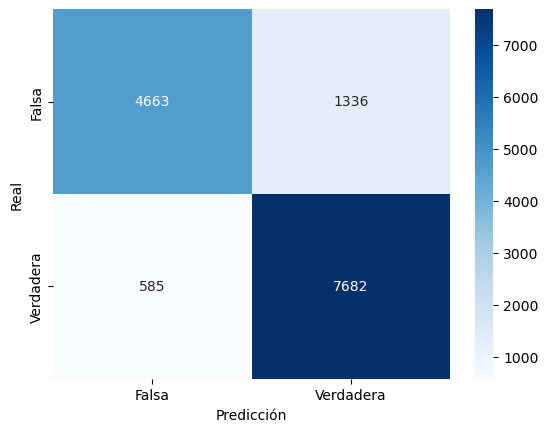

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Falsa', 'Verdadera'], yticklabels=['Falsa', 'Verdadera'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

In [ ]:
# from sklearn.model_selection import GridSearchCV
# param_grid = {'C': [0.1, 1.0, 10.0], 'max_iter': [1000, 2000]}
# grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='f1_weighted')
# grid_search.fit(X_train_balanced, y_train_balanced)
# modelo = grid_search.best_estimator_

# Random forest

In [ ]:
import re
df["combined_text"] = df["Titulo"].fillna("") + " " + df["Descripcion"].fillna("")


df["combined_text"] = df["combined_text"].apply(lambda x: re.sub(r'\d+', '', x))  # Elimina números


tfidf_vectorizer = TfidfVectorizer(max_features=5000)

vectorizacion = tfidf_vectorizer.fit_transform(df["combined_text"].fillna(""))

In [ ]:
palabras = tfidf_vectorizer.get_feature_names_out()
palabras

array(['abandona', 'abandonado', 'abandonar', ..., 'único', 'únicos',
       'útil'], dtype=object)

### Análisis desbalanceo de Clases

Lo primero es dividir los datos en el set de prueba y el set de entrenemiento, ya que la tecnica de SMOTE para corregir el desbalanceo de hace sobre los datos de entrenamiento.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(vectorizacion,df["Label"] , test_size=0.3, random_state=42)

Aplicar SMOTE para corregir el desbalanceo

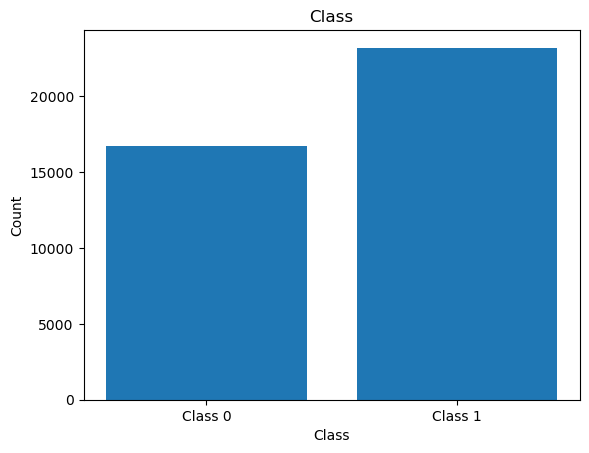

In [ ]:
y=y_train
x=y_train

count_class = y.value_counts() # Count the occurrences of each class
count_class.index
plt.bar(count_class.index, count_class.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class')
plt.xticks(count_class.index, ['Class 1', 'Class 0'])
plt.show()

In [ ]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

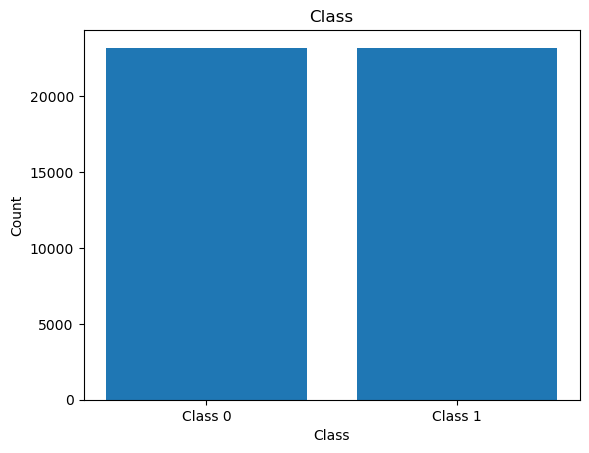

In [ ]:
y=y_train_balanced
x=y_train_balanced

count_class = y.value_counts() # Count the occurrences of each class
count_class.index
plt.bar(count_class.index, count_class.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class')
plt.xticks(count_class.index, ['Class 1', 'Class 0'])
plt.show()

Modelo con SMOTE

In [ ]:
# Initialize RandomForestClassifier
# Definir valores a probar


random_forest_with_somote = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_with_somote.fit(X_train_balanced, y_train_balanced)

y_prediccion = random_forest_with_somote.predict(X_test)

accuracy = accuracy_score(y_test, y_prediccion)
classification_rep = classification_report(y_test, y_prediccion)

print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", classification_rep)

Accuracy: 0.89

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.83      0.86      7171
           1       0.88      0.93      0.91      9948

    accuracy                           0.89     17119
   macro avg       0.89      0.88      0.88     17119
weighted avg       0.89      0.89      0.89     17119



Modelo sin SMOTE

Probando con el parámetro class_weight con el valor balanced para que el modelo ajuste los pesos de la clase minoritaria y tenga más influencia en la clasificación.

In [ ]:
random_forest_without_somote = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
random_forest_without_somote.fit(X_train, y_train)

y_prediccion = random_forest_without_somote.predict(X_test)

accuracy = accuracy_score(y_test, y_prediccion)
classification_rep = classification_report(y_test, y_prediccion)

print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", classification_rep)

Accuracy: 0.91

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.85      0.89      7171
           1       0.90      0.95      0.92      9948

    accuracy                           0.91     17119
   macro avg       0.91      0.90      0.91     17119
weighted avg       0.91      0.91      0.91     17119



Se puede ver que el uso de la tecnica SMOTE en este caso no funciona. Los cambios no son significativos y no se ven mejoras en el modelo.

Evaluar overfitting de los modelos

In [ ]:
# Evaluar en entrenamiento
train_accuracy = random_forest_with_somote.score(X_train, y_train)

# Evaluar en prueba
test_accuracy = random_forest_with_somote.score(X_test, y_test)

print(f"🔹 Accuracy en Train: {train_accuracy:.4f}")
print(f"🔹 Accuracy en Test: {test_accuracy:.4f}")

print(f"🔹 Diferencia Train-Test: {train_accuracy - test_accuracy:.4f}")

🔹 Accuracy en Train: 0.9994
🔹 Accuracy en Test: 0.8880
🔹 Diferencia Train-Test: 0.1115


In [ ]:
# Evaluar en entrenamiento
train_accuracy = random_forest_without_somote.score(X_train, y_train)

# Evaluar en prueba
test_accuracy = random_forest_without_somote.score(X_test, y_test)

print(f"🔹 Accuracy en Train: {train_accuracy:.4f}")
print(f"🔹 Accuracy en Test: {test_accuracy:.4f}")

print(f"🔹 Diferencia Train-Test: {train_accuracy - test_accuracy:.4f}")

🔹 Accuracy en Train: 0.9994
🔹 Accuracy en Test: 0.9099
🔹 Diferencia Train-Test: 0.0895


Entrenar el modelo con hiperparametros para aumentar el rendimiento del modelo.

In [ ]:
random_forest1 = RandomForestClassifier(n_estimators=100, min_samples_split=40,  max_leaf_nodes=500, class_weight="balanced", random_state=42)
random_forest1.fit(X_train, y_train)
#600
y_prediccion = random_forest1.predict(X_test)

accuracy = accuracy_score(y_test, y_prediccion)
classification_rep = classification_report(y_test, y_prediccion)

print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", classification_rep)

Accuracy: 0.91

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.85      0.89      7171
           1       0.90      0.96      0.93      9948

    accuracy                           0.91     17119
   macro avg       0.92      0.91      0.91     17119
weighted avg       0.92      0.91      0.91     17119



Evaluar overfitting del modelo

In [ ]:
# Evaluar en entrenamiento
train_accuracy = random_forest1.score(X_train, y_train)

# Evaluar en prueba
test_accuracy = random_forest1.score(X_test, y_test)

print(f"🔹 Accuracy en Train: {train_accuracy:.4f}")
print(f"🔹 Accuracy en Test: {test_accuracy:.4f}")

print(f"🔹 Diferencia Train-Test: {train_accuracy - test_accuracy:.4f}")

🔹 Accuracy en Train: 0.9419
🔹 Accuracy en Test: 0.9149
🔹 Diferencia Train-Test: 0.0270


Se puede ver que con el ajuste de hiperparámetros el overfitting del modelo se redujo.

Matriz de confusión

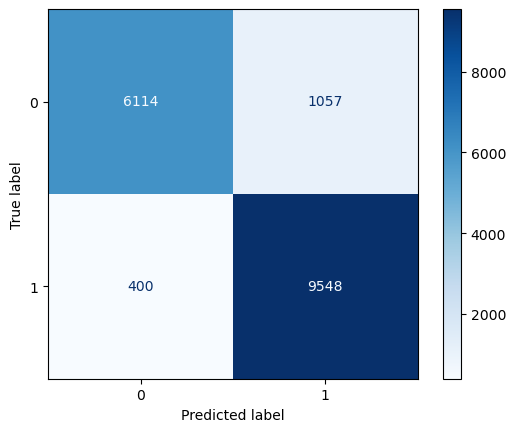

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_prediccion)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=random_forest1.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.show()


Análizando la matriz de confusión se puede decir que el modelo identificó erroneamente 1047 noticias verdaderas como noticias falsas. Por otro lado, 454 noticias falsas no fueron identificadas.

$$
\text{Exactitud} = \frac{6124 + 9494}{17119} = 0.9123
$$

Precisión 

$$
\text{Presición} = \frac{VP}{VP + FP} = \frac{9494}{9494 + 1047} = 0.90
$$

El modelo tiene una precisión del 90%, lo que significa que de todas las noticias clasificadas como falsas, el 90% realmente lo son. Esto indica un alto nivel de confianza en las predicciones positivas del modelo.

Recall

$$
\text{Recall} = \frac{VP}{VP + FN} = \frac{9494}{9494 + 454} = 0.95
$$

El modelo es capaz de identificar correctamente el 95% de las noticias falsas. Esto indica que solo el 5% de las noticias falsas no fueron detectadas, o sea, fueron clasificadas incorrectamente como verdaderas.

### Importancia de palabras

In [ ]:
importancia = random_forest1.feature_importances_
importancia

array([2.07925412e-05, 1.52237506e-05, 1.72066042e-05, ...,
       6.27674064e-05, 1.15736341e-05, 4.14461925e-06])

In [ ]:
palabras_importancia = pd.DataFrame({
    'Palabra': palabras,
    'Importancia': importancia
})
palabras_importancia

,Palabra,Importancia
0,abandona,0.000021
1,abandonado,0.000015
2,abandonar,0.000017
3,abandonó,0.000018
4,abascal,0.000739
...,...,...
4995,única,0.000039
4996,únicamente,0.000008
4997,único,0.000063
4998,únicos,0.000012


In [ ]:
top_n = 30
top_words = palabras_importancia.sort_values(by='Importancia', ascending=False).head(top_n)
top_words

,Palabra,Importancia
1765,equo,0.062822
3464,per,0.041542
595,bng,0.039866
4838,vers,0.036408
4508,sánchez,0.029829
3554,podemos,0.029464
1593,eaj,0.028044
1175,cristina,0.027127
3146,narbona,0.024741
2495,iniciativa,0.024266


## SVM

### Vectorización

Aquí se convierte el texto en vectores numéricos, capturando la importancia de cada palabra en el documento

Además se concatenan las columnas Titulo y Descripcion para aplicar TF-IDF sobre el texto completo.

In [ ]:
# Vectorización TF-IDF
tfidf = TfidfVectorizer(max_features=5000)  # Limitar a 5000 términos más frecuentes
X_tfidf = tfidf.fit_transform(df['Titulo'] + ' ' + df['Descripcion']).toarray()
X_tfidf_df = pd.DataFrame(X_tfidf, columns=[f'tfidf_{i}' for i in range(X_tfidf.shape[1])])

### División datos entrenamiento y prueba

Se divide el conjunto de datos en entrenamiento (75%) y prueba (25%), se usa un kernel lineal (kernel='linear') porque es adecuado para problemas de texto y es más interpretable.

In [ ]:
from sklearn.svm import LinearSVC
# Dividir los datos en entrenamiento y prueba
X = X_tfidf_df 
y = df['Label'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#### Crear y entrenar el modelo SVM

SVM es un modelo de clasificación que busca encontrar el hiperplano óptimo para separar las clases.

In [ ]:
modelo_svm = LinearSVC(C=1.0, random_state=42, dual=False)  # Kernel lineal y parámetro C=1.0
modelo_svm.fit(X_train, y_train)

LinearSVC(dual=False, random_state=42)

### Validación Cruzada k-Fold

La validación cruzada (k-Fold) divide los datos en k=5 subconjuntos y evalúa el modelo en cada uno ,proporcionando una estimación más robusta del rendimiento del modelo.

In [ ]:
# Validación cruzada con k=5
scores = cross_val_score(modelo_svm, X, y, cv=5, scoring='accuracy')

# Mostrar los resultados
print("Puntuaciones de validación cruzada:", scores)
print("Precisión promedio:", scores.mean())

Puntuaciones de validación cruzada: [0.90817489 0.91071585 0.90449487 0.90562566 0.90764108]
Precisión promedio: 0.9073304699331775


### Evaluación del Modelo con Métricas


Reporte completo:
              precision    recall  f1-score   support

       Falsa       0.92      0.85      0.88      5999
   Verdadera       0.90      0.94      0.92      8267

    accuracy                           0.91     14266
   macro avg       0.91      0.90      0.90     14266
weighted avg       0.91      0.91      0.91     14266



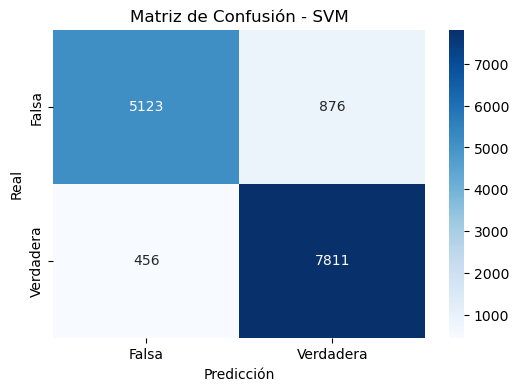

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predecir en el conjunto de prueba
y_pred = modelo_svm.predict(X_test)

# Calcular métricas
precision = accuracy_score(y_test, y_pred)
precision_clase_0 = precision_score(y_test, y_pred, pos_label=0)  # Precisión para la clase "Falsa"
precision_clase_1 = precision_score(y_test, y_pred, pos_label=1)  # Precisión para la clase "Verdadera"
recall_clase_0 = recall_score(y_test, y_pred, pos_label=0)       # Recall para la clase "Falsa"
recall_clase_1 = recall_score(y_test, y_pred, pos_label=1)       # Recall para la clase "Verdadera"
f1_clase_0 = f1_score(y_test, y_pred, pos_label=0)               # F1-score para la clase "Falsa"
f1_clase_1 = f1_score(y_test, y_pred, pos_label=1)               # F1-score para la clase "Verdadera"

# Reporte completo de clasificación
print("\nReporte completo:")
print(classification_report(y_test, y_pred, target_names=['Falsa', 'Verdadera']))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Falsa', 'Verdadera'], yticklabels=['Falsa', 'Verdadera'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - SVM')
plt.show()

### Ajuste de Hiperparámetros

GridSearchCV realiza una búsqueda exhaustiva sobre una grilla de hiperparámetros para encontrar los mejores valores.

El modelo se evalúa con validación cruzada (cv=5) y se selecciona la combinación de hiperparámetros que maximiza la precisión.

In [ ]:
# 1. Definir la grilla de hiperparámetros para LinearSVC
param_grid = {
    'C': [0.1, 1.0]  # Solo valores de C
}

# 2. Búsqueda de hiperparámetros
grid_search = GridSearchCV(LinearSVC(random_state=42, dual=False), param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# 3. Mostrar los mejores hiperparámetros
print("\nMejores hiperparámetros:", grid_search.best_params_)

# 4. Evaluar el modelo con los mejores hiperparámetros
mejor_modelo = grid_search.best_estimator_
y_pred_mejor = mejor_modelo.predict(X_test)
print("\nPrecisión del mejor modelo:", accuracy_score(y_test, y_pred_mejor))


Mejores hiperparámetros: {'C': 1.0}

Precisión del mejor modelo: 0.9066311509883639


### Métricas despues de aplicar hiperparametros

#### Calcular métricas para el modelo optimizado

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
precision_mejor = accuracy_score(y_test, y_pred_mejor)
precision_clase_0_mejor = precision_score(y_test, y_pred_mejor, pos_label=0)  # Precisión para la clase "Falsa"
precision_clase_1_mejor = precision_score(y_test, y_pred_mejor, pos_label=1)  # Precisión para la clase "Verdadera"
recall_clase_0_mejor = recall_score(y_test, y_pred_mejor, pos_label=0)       # Recall para la clase "Falsa"
recall_clase_1_mejor = recall_score(y_test, y_pred_mejor, pos_label=1)       # Recall para la clase "Verdadera"
f1_clase_0_mejor = f1_score(y_test, y_pred_mejor, pos_label=0)               # F1-score para la clase "Falsa"
f1_clase_1_mejor = f1_score(y_test, y_pred_mejor, pos_label=1)               # F1-score para la clase "Verdadera"

##### Reporte completo de clasificación para el modelo optimizado

In [ ]:
print("\nReporte completo (modelo optimizado):")
print(classification_report(y_test, y_pred_mejor, target_names=['Falsa', 'Verdadera']))


Reporte completo (modelo optimizado):
              precision    recall  f1-score   support

       Falsa       0.92      0.85      0.88      5999
   Verdadera       0.90      0.94      0.92      8267

    accuracy                           0.91     14266
   macro avg       0.91      0.90      0.90     14266
weighted avg       0.91      0.91      0.91     14266



#### Matriz de confusión para el modelo optimizado

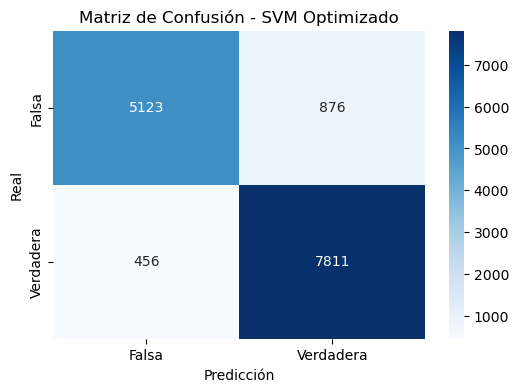

In [ ]:
cm_mejor = confusion_matrix(y_test, y_pred_mejor)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_mejor, annot=True, fmt='d', cmap='Blues', xticklabels=['Falsa', 'Verdadera'], yticklabels=['Falsa', 'Verdadera'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - SVM Optimizado')
plt.show()